### 라이브러리 연동

In [1]:
print(torch.cuda.get_device_name(), device = 0)

NameError: name 'torch' is not defined

In [2]:
import os
os.environ['TORCH_USE_CUDA_DSA'] = '1'

In [1]:
import sys
import torch

print("Python version")
print(sys.version)

print("\nPyTorch version")
print(torch.__version__)


Python version
3.9.16 (main, May 15 2023, 23:46:34) 
[GCC 11.2.0]

PyTorch version
2.0.0


In [2]:
import numpy as np
from matplotlib import pyplot as plt

import cv2 

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

In [3]:
import torch
print(torch.cuda.is_available())

True


In [4]:
# GPU 사용 가능 -> 가장 빠른 번호 GPU, GPU 사용 불가 -> CPU 자동 지정 예시
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

# GPU 이름 체크(cuda:0에 연결된 그래픽 카드 기준)
print(torch.cuda.get_device_name()) # 'NVIDIA TITAN X (Pascal)'

# 사용 가능 GPU 개수 체크
print(torch.cuda.device_count()) # 3

NVIDIA GeForce RTX 4080
1


In [8]:
# STL 10 데이터 활용 

transform = transforms.Compose([transforms.Resize(128), transforms.ToTensor()])
trainset = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=transform) # 96x96
trainloader = torch.utils.data.DataLoader(trainset, batch_size=40, shuffle=True)

# 10 classes = airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck

Files already downloaded and verified


In [9]:
model = torchvision.models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features # fc의 입력 노드 수를 산출한다. 512개
model.fc = nn.Linear(num_ftrs, 10) # fc를 nn.Linear(num_ftrs, 10)으로 대체한다.
model = model.to('cuda:0')

/home/minyoungxi/anaconda3/envs/minyoungxi/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/minyoungxi/anaconda3/envs/minyoungxi/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Model train

In [10]:
criterion = nn.CrossEntropyLoss() # 손실함수 
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-2) # 옵티마이저 정의

In [11]:
trainloader

In [12]:
for epoch in range(20):
    
    running_loss = 0.0
    for data in trainloader:
        
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    cost = running_loss / len(trainloader)
    print('[%d] loss: %.3f'%(epoch+1, cost))
    
torch.save(model.state_dict(), './stl10_resnet18.pth')

print('Finished Training')
        

[1] loss: 0.539
[2] loss: 0.094
[3] loss: 0.032
[4] loss: 0.031
[5] loss: 0.106
[6] loss: 0.142
[7] loss: 0.090
[8] loss: 0.059
[9] loss: 0.033
[10] loss: 0.061
[11] loss: 0.058
[12] loss: 0.076
[13] loss: 0.059
[14] loss: 0.077
[15] loss: 0.053
[16] loss: 0.060
[17] loss: 0.063
[18] loss: 0.067
[19] loss: 0.054
[20] loss: 0.057
Finished Training


In [13]:
correct = 0 
total = 0 

with torch.no_grad():
    for data in trainloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the train image : %d %%' % (100*correct / total))

Accuracy of the network on the train image : 98 %


### 98%로 분류한 이 Resnet18 모델이 도대체 어딜 보고 맞췄을까?


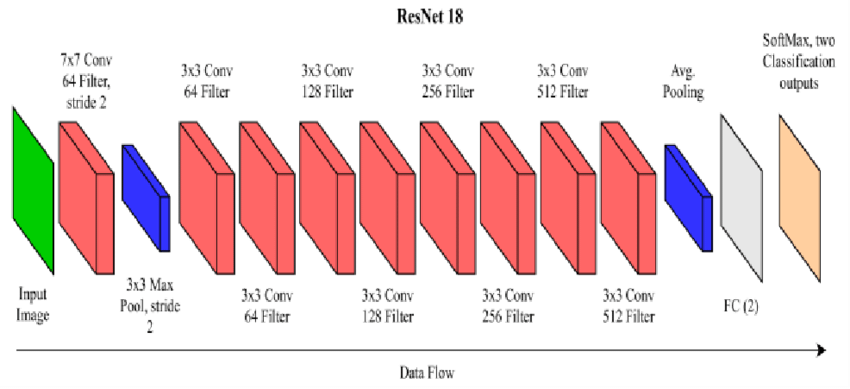

In [14]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

CAM은 Feature extraction의 마지막 feature map을 기준으로 시각화를 하는 모델입니다. ( Feature Extraction은 AvgPool 이전 단계 ) 



# CAM 모델 구축

In [16]:
# Visualize Feature map 

activation = {}

def get_activation(name): # 모델 내에서 feature map or filter 추출
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [17]:
def cam(model, trainset, img_sample, img_size):
    model.eval()
    with torch.no_grad(): # requires_grad 비활성화

        model.layer4[1].bn2.register_forward_hook(get_activation('final')) # feature extraction의 마지막 feature map 구하기
        data, label = trainset[img_sample] # 이미지 한 장과 라벨 불러오기
        data.unsqueeze_(0) # 4차원 3차원 [피쳐수 ,너비, 높이] -> [1,피쳐수 ,너비, 높이]
        output = model(data.to(device))
        _, prediction = torch.max(output, 1)
        act = activation['final'].squeeze() # 4차원 [1,피쳐수 ,너비, 높이] -> 3차원 [피쳐수 ,너비, 높이]
        w = model.fc.weight # classifer의 가중치 불러오기
        
        for idx in range(act.size(0)): # CAM 연산
            if idx == 0:
                tmp = act[idx] * w[prediction.item()][idx] 
            else:
                tmp += act[idx] * w[prediction.item()][idx]

        # 모든 이미지 팍셀값을 0~255로 스케일하기 
        normalized_cam = tmp.cpu().numpy()
        normalized_cam = (normalized_cam - np.min(normalized_cam)) / (np.max(normalized_cam) - np.min(normalized_cam))
        original_img = np.uint8((data[0][0] / 2 + 0.5) * 255)

        # 원본 이미지 사이즈로 리사이즈
        cam_img = cv2.resize(np.uint8(normalized_cam * 255), dsize=(img_size, img_size)) 
        
    return cam_img, original_img

In [20]:
def plot_cam(model, trainset, img_size, start):
    end = start + 20 # 이미지 출력 개수
    fig, axs = plt.subplots(2, (end - start + 1) // 2, figsize=(20, 5))
    fig.subplots_adjust(hspace=.01, wspace=.01)
    axs = axs.ravel()

    for i in range(start, end):
        cam_img, original_img = cam(model, trainset, i, img_size)
        
        # original img를 먼저 불러오고 그 위에 cam 이미지를 덮어씌워서 출력
        axs[i - start].imshow(original_img, cmap='gray') # original img . gray로 해준 이유는 cam의 색을 잘 보이게 하기 위해
        axs[i - start].imshow(cam_img, cmap='jet', alpha=.5) # cam img 
        axs[i - start].axis('off')

    plt.show()
    fig.savefig('cam.png')

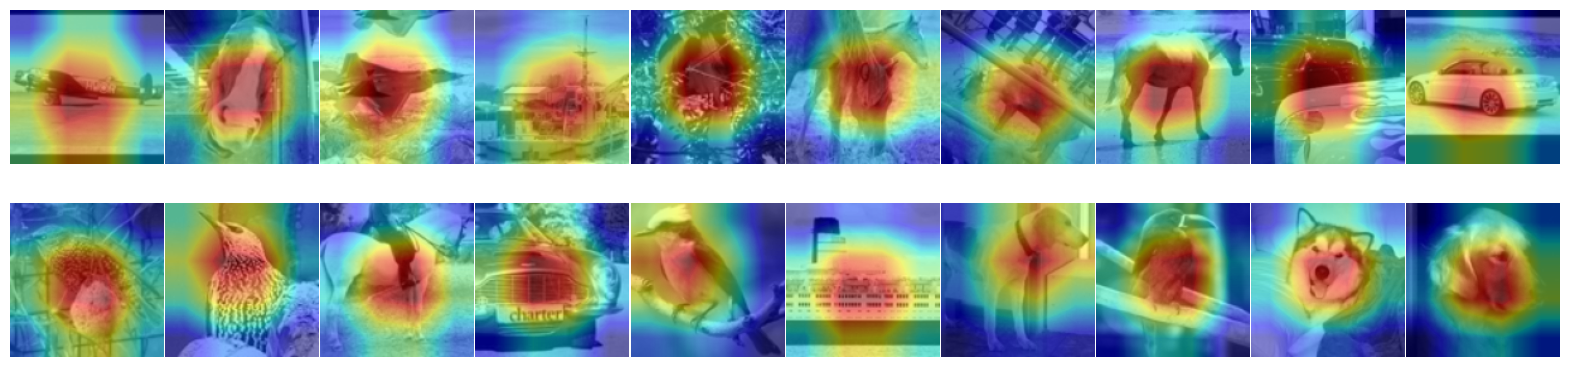

In [21]:
plot_cam(model, trainset, 128, 10)